# Generate tree for alphatectiviruses

In [2]:
import os
import pandas as pd
from Bio import SeqIO
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# gather all genomes of new and previous alphatectiviruses

records = []

assemblies_dir = '../../../genomes/data/assemblies_oriented/'

# these are redundant in our collection
exclude = ['PRDcoral.fasta', 'PRDmauve.fasta', 'PRDsalmon.fasta']

# append to list all of our assembled alphatectis, except PRD1
for assembly in os.listdir(assemblies_dir):
    if assembly.startswith('PRD'):
           if assembly not in exclude:
            path = os.path.join(assemblies_dir, assembly)
            if assembly != 'PRD1.fasta':
                record = list(SeqIO.parse(path, 'fasta'))[0]
                record.id = assembly.split('.fasta')[0]
                record.description = ''
                records.append(record)

                
# ppend to list all previously isolated tectiviruses
previous_dir = 'data/previous_alphatv'

for assembly in os.listdir(previous_dir):
    if assembly.endswith('.fasta'):
        path = os.path.join(previous_dir, assembly)
        record = list(SeqIO.parse(path, 'fasta'))[0]
        record.id = assembly.split('.fasta')[0]
        record.description = ''
        records.append(record)

In [4]:
alphatv_fasta = 'data/alphatv.fasta'
#SeqIO.write(records, alphatv_fasta, 'fasta')

## Align with `clustalo`

In [5]:
alphatv_afa = 'data/alphatv.msa.fasta'
clustal_cmd = f'clustalo -i {alphatv_fasta} -o {alphatv_afa} --outfmt=fa'

print(clustal_cmd)

clustalo -i data/alphatv.fasta -o data/alphatv.msa.fasta --outfmt=fa


## Manually trim edges and fix alignment errors

In [6]:
# manually curated and removed non-resolved ends and stored as:
alphatv_afa_trim = 'data/alphatv.msa.trim.fasta'

## Build tree with `iqtree`

In [7]:
iqtree_cmd = f'iqtree -st DNA -m MFP -bb 1000 -alrt 1000 -s {alphatv_afa_trim}'

print(iqtree_cmd)

iqtree -st DNA -m MFP -bb 1000 -alrt 1000 -s data/alphatv.msa.trim.fasta


## Tree drawing
- Drawn with [https://itol.embl.de/](https://itol.embl.de/)
- Saved as `data/svg/alphatv.tree.svg` and `data/svg/alphatv.tree.labeled.svg`
- Colored according to assignments (see below)

# Pairwise %id

## Calculate with `esl-alipid` and plot

In [17]:
alphatv_pid = 'data/pid.tbl'

esl_cmd = f'esl-alipid {alphatv_afa_trim} > {alphatv_pid}'

print(esl_cmd)

esl-alipid data/alphatv.msa.trim.fasta > data/pid.tbl


In [18]:
#! $esl_cmd

In [19]:
# read table
alphatv_pid = 'data/pid.tbl'

df1 = pd.read_csv(alphatv_pid, delim_whitespace=True, comment='#', header=None)
df1.columns = ['seq1', 'seq2', 'p_id', 'nid', 'denomid', 'p_match', 'n_match', 'denommatch']
df1 = df1.sort_values('p_id', ascending=False)

In [20]:
# fill other values to make symetrical matrix
df2 = df1.rename(columns={'seq1': 'a', 'seq2': 'b'})
df2 = df2.rename(columns={'a': 'seq2', 'b': 'seq1'})

df_sym = pd.concat([df1, df2])

In [21]:
df_sym.sort_values('p_id')

,seq1,seq2,p_id,nid,denomid,p_match,n_match,denommatch
190,PRDvermilion,PRDpistachio,82.50,12147,14723,98.71,14641,14832
190,PRDpistachio,PRDvermilion,82.50,12147,14723,98.71,14641,14832
918,PRDpistachio,PRDcarrot,82.52,12160,14736,98.63,14641,14845
918,PRDcarrot,PRDpistachio,82.52,12160,14736,98.63,14641,14845
1174,PRDpistachio,PRDshaddybee,82.57,12127,14687,98.52,14609,14828
...,...,...,...,...,...,...,...,...
1536,PRDjet,PRDmaroon,98.54,14500,14715,99.95,14714,14721
24,PRDturquoise,PRDmahogany,99.00,14505,14651,99.55,14648,14714
24,PRDmahogany,PRDturquoise,99.00,14505,14651,99.55,14648,14714
1651,PR3,L17,99.82,14687,14713,100.00,14713,14713


In [22]:
df_sym[(df_sym['seq1'] == 'PRD1') & (df_sym['seq2'] == 'PRDcerulean')]

,seq1,seq2,p_id,nid,denomid,p_match,n_match,denommatch
829,PRD1,PRDcerulean,95.6,14060,14707,99.65,14689,14741


In [23]:
# make matrix
m = df_sym.pivot_table(index='seq1', columns='seq2', values='p_id', fill_value=100)

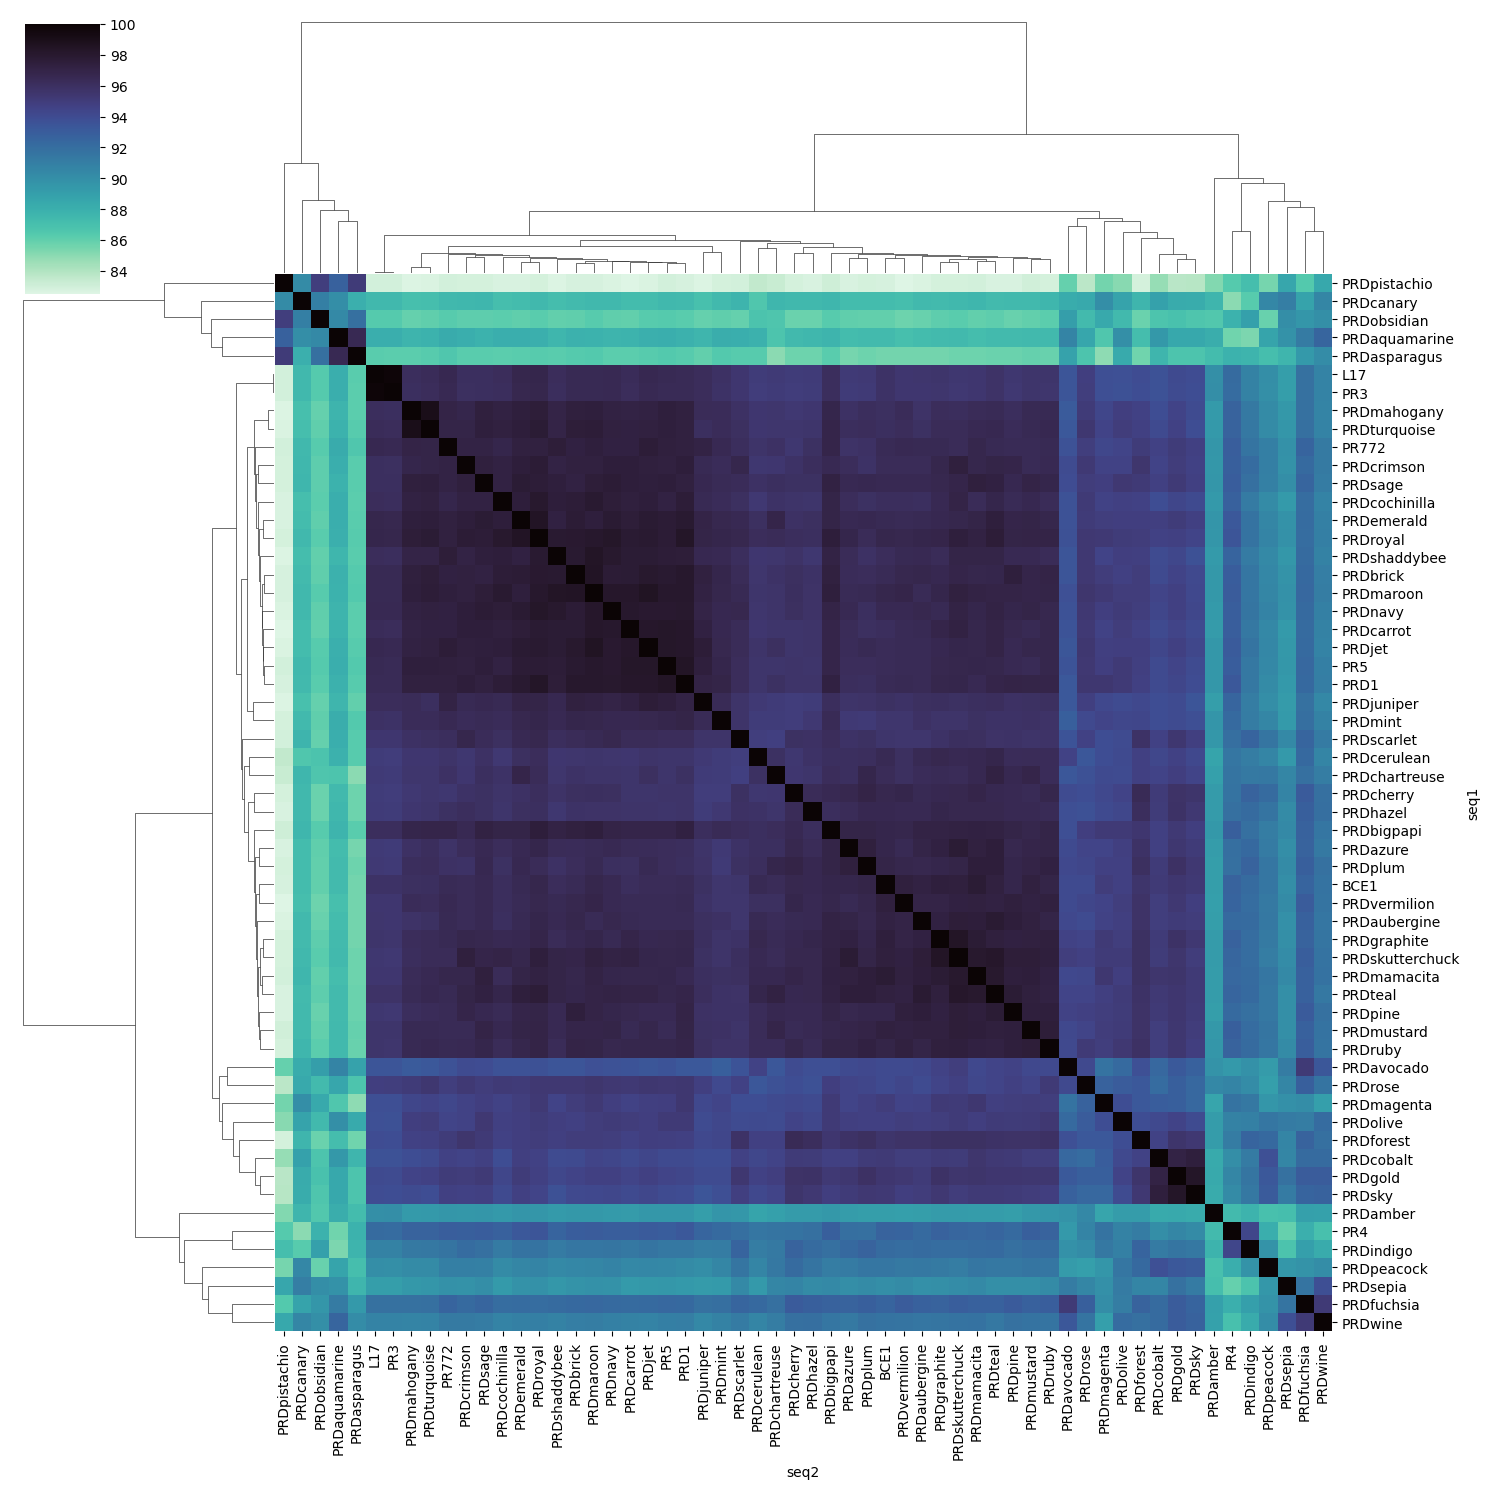

In [24]:
g = sns.clustermap(m, cmap="mako_r", figsize=(15, 15))
#plt.savefig('./data/pid.svg')

## Group phages by >95% pid

In [25]:
proposed_species = ['PRD1', 'PR4', 'PRDpistachio', 
                    'PRDavocado', 'PRDcobalt', 'PRDindigo', 
                    'PRDsepia', 'PRDcanary', 'PRDaquamarine', 
                    'PRDwine', 'PRDamber', 'PRDpeacock', 
                    'PRDforest', 'PRDobsidian']

### Make sure proposed species don't overlap

In [26]:
df_simplified = df_sym[['seq1', 'seq2', 'p_id']]

In [27]:
overlap = df_simplified[(df_simplified['seq1'].isin(proposed_species) & (df_simplified['seq2'].isin(proposed_species)))]

In [28]:
overlap[overlap['p_id'] > 95]

,seq1,seq2,p_id


### Get assignments

In [30]:
df_fill = pd.DataFrame([proposed_species, proposed_species, [100] * len(proposed_species)]).T
df_fill.columns = ['seq1', 'seq2', 'p_id']
df_simplified = pd.concat([df_simplified, df_fill])

In [31]:
dict_assignment = {}


for phage in list(df_simplified['seq1'].unique()):
    # subset dataframe for that phage, compared to the proposed species list
    df_best = df_simplified[(df_simplified['seq1'] == phage) & (df_simplified['seq2'].isin(proposed_species))]

    # sort pid values
    df_best = df_best.sort_values('p_id', ascending=False)

    # select higest pid value (best match to a proposed species)
    best = df_best['seq2'].to_list()[0]

    # add to dictionary
    if best not in dict_assignment.keys():
        dict_assignment[best] = []

    dict_assignment[best].append(phage)

In [32]:
list_assignments = []

for species in dict_assignment.keys():
    
    df = df_simplified[(df_simplified['seq1'] == species) & (df_simplified['seq2'].isin(dict_assignment[species]))]
    
    df = df[['seq1', 'seq2', 'p_id']]
    df.columns = ['species', 'isolate', 'p_id']
    
    list_assignments.append(df)

df_assignments = pd.concat(list_assignments)

In [33]:
df_assignments = df_assignments.sort_values(by=['species', 'p_id'], ascending=[True, False])
df_assignments = df_assignments.reset_index(drop=True)

In [34]:
df_assignments['species'].value_counts()

PRD1             40
PRDcobalt         4
PRDforest         4
PRDaquamarine     3
PRDwine           3
PR4               2
PRDamber          2
PRDavocado        2
PRDcanary         2
PRDindigo         2
PRDobsidian       2
PRDpeacock        2
PRDpistachio      2
PRDsepia          2
Name: species, dtype: int64